# BERT文本分类

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

本范例我们微调transformers中的BERT来处理文本情感分类任务。

我们的数据集是美团外卖的用户评论数据集。

模型目标是把评论分成好评(标签为1)和差评(标签为0)。



In [1]:
#安装库
#!pip install datasets 
#!pip install transformers[torch]
#!pip install torchkeras

## 一，准备数据

准备数据阶段主要需要用到的是datasets.Dataset 和transformers.AutoTokenizer。


### 1，数据加载

HuggingFace的datasets库提供了类似TensorFlow中的tf.data.Dataset的功能。

In [2]:
import numpy as np 
import pandas as pd 

import torch 
from torch.utils.data import DataLoader 

import datasets 


In [3]:
df = pd.read_csv("data/waimai_10k.csv")
ds = datasets.Dataset.from_pandas(df) 
ds = ds.shuffle(42) #打乱顺序
ds = ds.rename_columns({"review":"text","label":"labels"})


In [4]:
ds[0]

{'labels': 0, 'text': '晚了半小时，七元套餐饮料就给的罐装的可乐，真是可以'}

In [5]:
ds[0:4]["text"]

['晚了半小时，七元套餐饮料就给的罐装的可乐，真是可以',
 '很好喝！天天都喝～～',
 '东西很少，像半分每次都是这样失望',
 '配送比较慢（不是高峰时间点的结果1个多小时才送到）；菜品备注了“老人吃请少油少盐”，结果还是很咸很油，哎…失望']

### 2，文本分词

transformers库使用tokenizer进行文本分词。


In [6]:
from transformers import AutoTokenizer #BertTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese') #需要和模型一致
print(tokenizer) 


BertTokenizerFast(name_or_path='bert-base-chinese', vocab_size=21128, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [7]:
#tokenizer可以使用 __call__,encode,encode_plus,batch_encode_plus等方法编码
#可以使用decode,batch_decode等方法进行解码
text_codes = tokenizer(text = '晚了半小时，七元套餐饮料就给的罐装的可乐，真是可以',
                       text_pair = None,
                       max_length = 100, #为空则默认为模型最大长度，如BERT是512,GPT是1024
                       truncation = True,
                       padding= 'do_not_pad') #可选'longest','max_length','do_not_pad'

#input_ids是编码后的数字，token_type_ids表示来自第1个句子还是第2个句子
#attention_mask在padding的位置是0其它位置是1
print(text_codes) 


{'input_ids': [101, 3241, 749, 1288, 2207, 3198, 8024, 673, 1039, 1947, 7623, 7650, 3160, 2218, 5314, 4638, 5380, 6163, 4638, 1377, 727, 8024, 4696, 3221, 1377, 809, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [8]:
tokenizer.decode(text_codes["input_ids"][0])

'[CLS]'

In [9]:
tokenizer.batch_decode(text_codes["input_ids"])

['[CLS]',
 '晚',
 '了',
 '半',
 '小',
 '时',
 '，',
 '七',
 '元',
 '套',
 '餐',
 '饮',
 '料',
 '就',
 '给',
 '的',
 '罐',
 '装',
 '的',
 '可',
 '乐',
 '，',
 '真',
 '是',
 '可',
 '以',
 '[SEP]']

In [10]:
tokens = tokenizer.tokenize(ds['text'][0])
print("tokens=",tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print("ids = ",ids)


tokens= ['晚', '了', '半', '小', '时', '，', '七', '元', '套', '餐', '饮', '料', '就', '给', '的', '罐', '装', '的', '可', '乐', '，', '真', '是', '可', '以']
ids =  [3241, 749, 1288, 2207, 3198, 8024, 673, 1039, 1947, 7623, 7650, 3160, 2218, 5314, 4638, 5380, 6163, 4638, 1377, 727, 8024, 4696, 3221, 1377, 809]


### 3，传入DataLoader

In [11]:
ds_encoded = ds.map(lambda example:tokenizer(example["text"],
                    max_length=50,truncation=True,padding='max_length'),
                    batched=True,
                    batch_size=20,
                    num_proc=2) #支持批处理和多进程map 


Map (num_proc=2):   0%|          | 0/11987 [00:00<?, ? examples/s]

In [12]:
#转换成pytorch中的tensor 
ds_encoded.set_format(type="torch",columns = ["input_ids",'attention_mask','token_type_ids','labels'])
#ds_encoded.reset_format() 
ds_encoded[0]


{'labels': tensor(0),
 'input_ids': tensor([ 101, 3241,  749, 1288, 2207, 3198, 8024,  673, 1039, 1947, 7623, 7650,
         3160, 2218, 5314, 4638, 5380, 6163, 4638, 1377,  727, 8024, 4696, 3221,
         1377,  809,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])}

In [13]:
#分割成训练集和测试集
ds_train_val,ds_test = ds_encoded.train_test_split(test_size=0.2).values()
ds_train,ds_val = ds_train_val.train_test_split(test_size=0.2).values() 


In [14]:
#在collate_fn中可以做动态批处理(dynamic batching)

def collate_fn(examples):
    return tokenizer.pad(examples) #return_tensors='pt'

#以下方式等价
#from transformers import DataCollatorWithPadding
#collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, collate_fn = collate_fn)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=16,  collate_fn = collate_fn)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=16,  collate_fn = collate_fn)


In [15]:
for batch in dl_train:
    break 

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## 二，定义模型

一个完整的模型(Model)包括模型架构(Architecture)和模型权重(Checkpoints/Weights)。

transformers提供了3种指定模型架构的方法。

* 第1种是指定模型架构(如: from transformers import BertModel)

* 第2种是自动推断模型架构(如: from transformers import AutoModel)

* 第3种是自动推断模型架构并自动添加Head (如: from transformers import AutoModelForSequenceClassification )

第1种方案和第2种方案用户可以灵活地根据自己要做的任务设计Head，并且需要对基础模型有一定的了解。


此处我们使用第3种方案。


In [16]:
from transformers import AutoModelForSequenceClassification 

#加载模型 (会添加针对特定任务类型的Head)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-chinese',num_labels=2)
dict(model.named_children()).keys() 


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

dict_keys(['bert', 'dropout', 'classifier'])

我们可以用一个batch的数据去试算一下

In [17]:
output = model(**batch)

In [18]:
output.loss 

tensor(0.6762, grad_fn=<NllLossBackward0>)

## 三，训练模型

下面使用我们的梦中情炉 torchkeras 来实现最优雅的微调训练循环。🤗🤗



In [19]:
from torchkeras import KerasModel 

#我们需要修改StepRunner以适应transformers的数据集格式

class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        out = self.net(**batch)
        
        #loss
        loss= out.loss
        
        #preds
        preds =(out.logits).argmax(axis=1) 
    
        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
        
        all_loss = self.accelerator.gather(loss).sum()
        
        labels = batch['labels']
        acc = (preds==labels).sum()/((labels>-1).sum())
        
        all_acc = self.accelerator.gather(acc).mean()
        
        #losses
        step_losses = {self.stage+"_loss":all_loss.item(), self.stage+'_acc':all_acc.item()}
        
        #metrics
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

keras_model = KerasModel(model,
                   loss_fn=None,
                   optimizer = optimizer
                   )


<<<<<< ⚡️ cuda is used >>>>>>


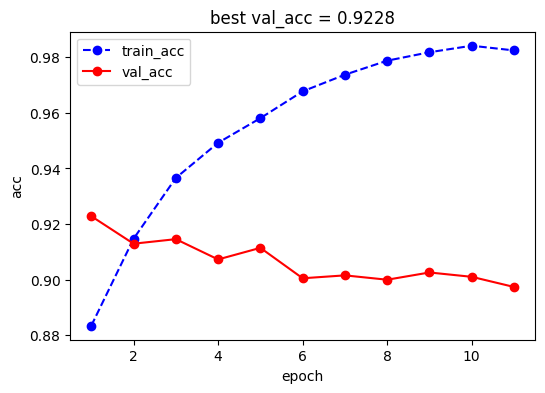

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>>


,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,0.306164,0.883464,0.00003,0.224274,0.922842
1,2,0.225757,0.914714,0.00003,0.221378,0.912946
2,3,0.181335,0.936589,0.00003,0.249262,0.914583
3,4,0.150235,0.949219,0.00003,0.265122,0.907292
4,5,0.122353,0.958073,0.00003,0.300408,0.911458
5,6,0.096260,0.967708,0.00003,0.287057,0.900521
6,7,0.081176,0.973698,0.00003,0.356954,0.901563
7,8,0.065423,0.978739,0.00003,0.354140,0.900000
8,9,0.051379,0.981771,0.00003,0.397223,0.902604
9,10,0.046847,0.984115,0.00003,0.412438,0.901042


In [21]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='bert_waimai.pt',
    epochs=100,
    patience=10,
    monitor="val_acc", 
    mode="max",
    plot = True,
    wandb = False,
    quiet = True
)


## 四，评估模型

可以使用huggingFace的evaluate库来进行模型评估。

通过evaluate的load方法可以加载一些常用的评估指标。

可以用add_batch逐批次地往这些评估指标上添加数据，最后用compute计算评估结果。

In [ ]:
!pip install evaluate 

In [23]:
import evaluate
metric = evaluate.load("accuracy")
model.eval()
dl_test = keras_model.accelerator.prepare(dl_test)
for batch in dl_test:
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9128440366972477}

## 五，使用模型

In [24]:
texts = ["味道还不错，下次再来","这他妈也太难吃了吧","感觉不是很新鲜","还行我家狗狗很爱吃"]
batch = tokenizer(texts,padding=True,return_tensors="pt")
batch = {k:v.to(keras_model.accelerator.device) for k,v in batch.items()}


In [25]:
from torch import nn 
logits = model(**batch).logits 
scores = nn.Softmax(dim=-1)(logits)[:,-1]
print(scores)
#可以看到得分与人的预期是高度一致的

tensor([0.9510, 0.0133, 0.1020, 0.6223], device='cuda:0',
       grad_fn=<SelectBackward0>)


也可以用pipeline把tokenizer和model组装在一起

In [26]:
from transformers import pipeline
classifier = pipeline(task="text-classification",tokenizer = tokenizer,model=model.cpu())
classifier("挺好吃的哦")

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'LABEL_1', 'score': 0.9468138813972473}]

## 六，保存模型

保存model和tokenizer之后，我们可以用一个pipeline加载，并进行批量预测。


In [27]:
model.config.id2label = {0:"差评",1:"好评"}
model.save_pretrained("waimai_10k_bert")
tokenizer.save_pretrained("waimai_10k_bert")


('waimai_10k_bert/tokenizer_config.json',
 'waimai_10k_bert/special_tokens_map.json',
 'waimai_10k_bert/vocab.txt',
 'waimai_10k_bert/added_tokens.json',
 'waimai_10k_bert/tokenizer.json')

In [28]:
from transformers import pipeline 
classifier = pipeline("text-classification",model="waimai_10k_bert")


In [29]:
classifier(["味道还不错，下次再来","我去，吃了我吐了三天"])

[{'label': '好评', 'score': 0.950958251953125},
 {'label': '差评', 'score': 0.9617311954498291}]

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)